# Operation IceBridge SnowRadar (2-8 GHz) Example

Example of using wavelet picker with CRESIS 2-8 GHz snow radar data (MATFILE)

In [1]:
# #pySnowRadar modules
import sys    # return relevant_atm_data
sys.path.append('/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/pySnowRadar')
from pySnowRadar import SnowRadar
from pySnowRadar.processing import *
from pySnowRadar.algorithms import Wavelet_TN, Peakiness

# from msc_thesis_functions import *
# del sys.modules['msc_thesis_functions']
# from msc_thesis_functions import *
#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py


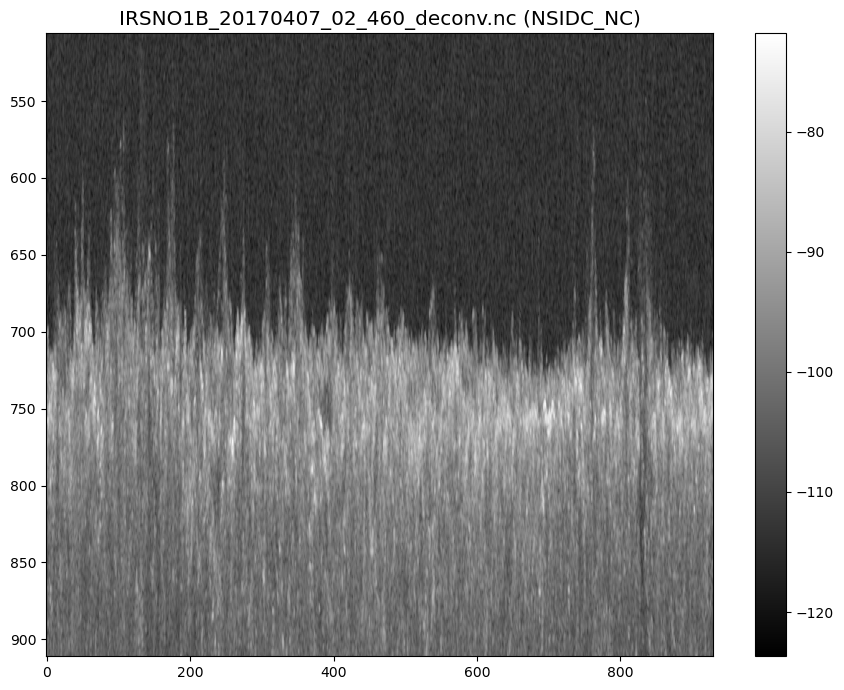

In [18]:
radar_file = '/Users/torka/Downloads/223038897/IRSNO1B_20170407_02_460_deconv.nc'
radar_dat2 = SnowRadar(radar_file, l_case='full')
time_min = radar_dat2.time_utc.min()
time_max = radar_dat2.time_utc.max()


# Find surface and trim data
radar_dat2.surf_bin, radar_dat2.surface = radar_dat2.get_surface()
radar_bounds = radar_dat2.get_bounds(2,1)
radar_dat2.plot_quicklook(ylim = list(radar_bounds))
# df_ATM_subset = df_ATM.loc[(df_ATM['time'] > time_min) & (df_ATM['time'] < time_max)]

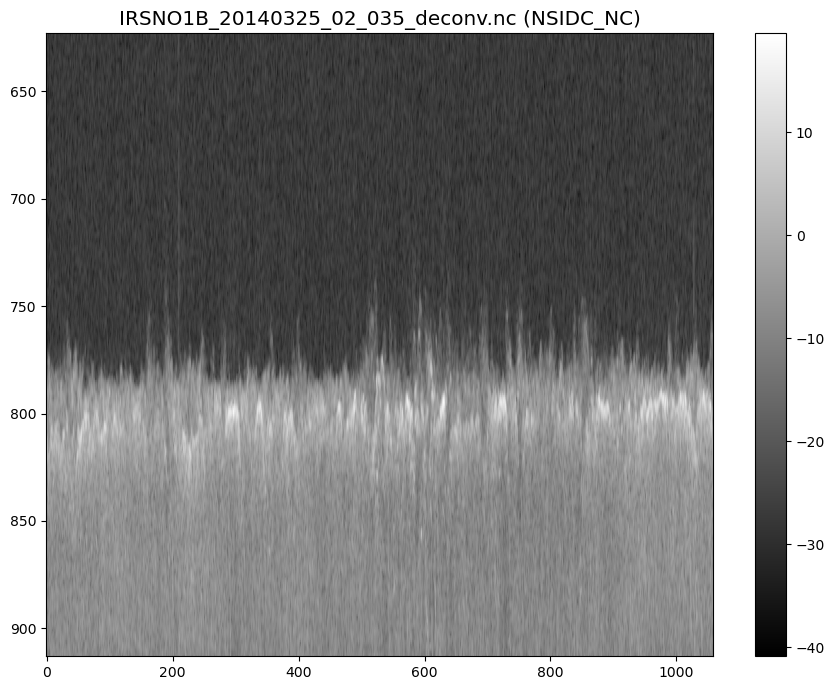

In [2]:
radar_file = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Echograms/20140325/71729489/IRSNO1B_20140325_02_035_deconv.nc'
radar_dat = SnowRadar(radar_file, l_case='full')
time_min = radar_dat.time_utc.min()
time_max = radar_dat.time_utc.max()


# Find surface and trim data
radar_dat.surf_bin, radar_dat.surface = radar_dat.get_surface()
radar_bounds = radar_dat.get_bounds(2,1)    
radar_dat.plot_quicklook(ylim = list(radar_bounds))
# df_ATM_subset = df_ATM.loc[(df_ATM['time'] > time_min) & (df_ATM['time'] < time_max)]

(600.0, 1000.0)

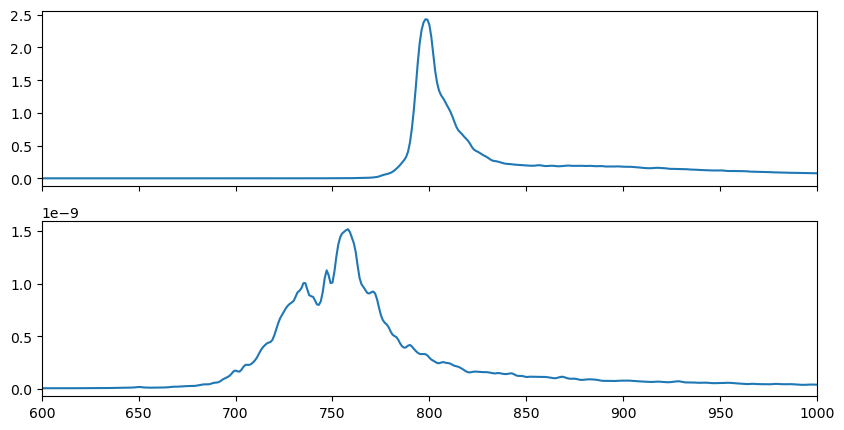

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)

ax[0].plot(np.mean(radar_dat.data_radar[:,:], axis=1))
ax[1].plot(np.mean(radar_dat2.data_radar[:,:], axis=1))

ax[1].set_xlim(600,1000)


### TESTING PEAKINESS NUMBER OF RANGE BINS

In [134]:
from scipy.signal import find_peaks
log_peak_threshold = 0.6
lin_peak_threshold = 0.2
pp_l_threshold = 20
pp_r_threshold = 20
n_snow = np.sqrt((1 + 0.51 * 0.3) ** 3)
# params['null_2_space']  = radar_dat.n2n
delta_fast_time_range = radar_dat.dfr
data = radar_dat.data_radar[:,675]

In [135]:
data = data[~np.isnan(data)]
#normalize data
data_norm = data / np.nanmax(data)
#log-scale normalized data
data_norm_dB = 10 * np.log10(data_norm)

#Calculate noise
noise_mean = np.nanmean(data_norm_dB[0:100])

#Find logarithmic data peaks that are above the mean noise level by log_peak_threshold
logpeaks,_ = find_peaks(data_norm_dB, height = noise_mean + log_peak_threshold * (np.nanmax(data_norm_dB) - noise_mean))

#Calculate left-hand peakiness value for the logarithmic data peaks from the linear normalized data

# BELOW VALUE IS CHANGED FROM 10 TO 5 FOR EXPERIMENTAL PURPOSES with the 2-8 GHz radar
range_bins = 10 #equals to approximately 2 x 3-dB range resolution (~8 cm)


PP_L_log = []
for peak in logpeaks:
    print(peak, str(data_norm[peak] / np.mean(data_norm[peak - range_bins:peak]) * range_bins))
    PP_L_log.append(data_norm[peak] / np.mean(data_norm[peak - range_bins:peak]) * range_bins)

#Find where the left-hand peakiness values fulfill the threshold value
valid_PP_L = np.argwhere(np.array(PP_L_log) >= pp_l_threshold).flatten()

#Find linear data peaks that are above the lin_peak_threshold
linpeaks,_ = find_peaks(data_norm, height = lin_peak_threshold)

#If more than five peaks in the linear data were detected, the waveform is determined as ambiguous and no interfaces are returned.
# if len(linpeaks) > 5:
#     locs_as = np.nan
#     locs_si = np.nan
# else:    
#Calculate right-hand peakiness value for the linear data peaks from the linear normalized data
PP_R_lin = []
for peak in linpeaks:
    PP_R_lin.append(data_norm[peak] / np.mean(data_norm[peak + 1:peak + 1 + range_bins]) * range_bins)

    #Find where the right-hand peakiness values are valid: filter according to pp_r_threshold, but including the maximum return, and including peaks only within 1.5 m from the estimated air-snow interface
valid_PP_R = np.argwhere(((np.array(PP_R_lin) >= pp_r_threshold) | 
                            (linpeaks == np.argmax(data_norm))) & 
                            (linpeaks < logpeaks[0] + np.ceil(1.5 / (delta_fast_time_range / n_snow)).astype(int))).flatten()

#If no valid peaks after filtering, set interface locations to NaN
if (len(valid_PP_L) == 0) or (len(valid_PP_R) == 0):
    locs_as = np.nan
    locs_si = np.nan
else: #Filter peak locations
    logpeaks = logpeaks[valid_PP_L]
    linpeaks = linpeaks[valid_PP_R]
                        
    #Make sure that the assumed air-snow interface comes before the snow-ice interface
    if (logpeaks[0] > linpeaks[-1]):
        locs_as = np.nan
        locs_si = np.nan
    else:
        #Air-snow interface is located at the first valid logarithmic data peak
        locs_as = 1.0 * logpeaks[0]
        #Snow-ice interface is located at the last valid linear data peak
        locs_si = 1.0 * linpeaks[-1]


744 19.360885620117188
770 14.173716306686401
788 20.87214946746826
807 15.065017938613892
828 14.940491914749146
834 9.319372773170471
847 5.966234803199768
853 12.697404623031616
868 14.625338315963745
876 8.924559354782104
884 14.325263500213623
900 22.054436206817627
915 12.878806591033936
928 15.953059196472168
942 9.153923392295837
952 13.210763931274414
986 16.542357206344604
995 6.743451952934265


(650.0, 1000.0)

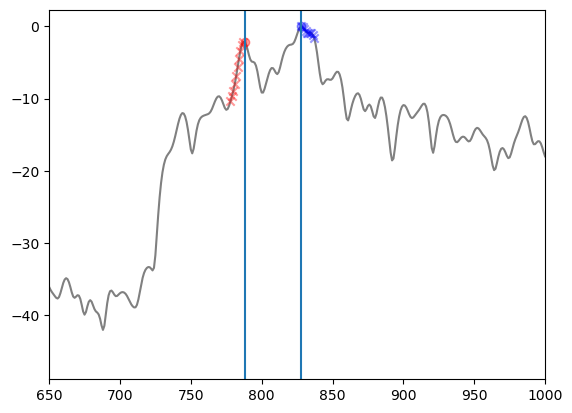

In [136]:
plt.plot(data_norm_dB,zorder=0, color='grey')
plt.scatter(logpeaks[0], data_norm_dB[logpeaks[0]], color = 'r', zorder=1, alpha=.4)
plt.scatter(np.arange(logpeaks[0]-range_bins,logpeaks[0] ,1), data_norm_dB[logpeaks[0] - range_bins:logpeaks[0]], color = 'r', zorder=1, alpha=.4, marker='x')


plt.scatter(linpeaks[0], data_norm_dB[linpeaks[0]], color = 'b', zorder=1, alpha=.4)
plt.scatter(np.arange(linpeaks[0],linpeaks[0]+range_bins ,1), data_norm_dB[linpeaks[0] :linpeaks[0]+range_bins], color = 'b', zorder=1, alpha=.4, marker='x')


plt.axvline(locs_as)
plt.axvline(locs_si)

plt.xlim(650,1000)

## Application of wavelet picker

In [3]:
# Set up picker parameters and extract interfaces using the Newman wavelet

#these are the input parameters from Fredensborg-Hansen (2024), "Exploring [...]" for Antarctic summer sea ice/ snow
# ATM_folder = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM/2016'
# ATM_folder = '/Volumes/PortableSSD/ATM_levelled_classified_v2'

params_peaki ={
        'snow_density': 0.3,
        'log_peak_threshold' : 0.4,
        'lin_peak_threshold' : 0.4, 
        'pp_r_threshold' : 30, 
        'pp_l_threshold' : 30
        }

params_TN ={'snow_density':0.3,
            'ref_snow_layer': .5,
            'cwt_precision': 10
            }

res_TN = extract_layers(radar_file,
                        picker=Wavelet_TN,
                        params=params_TN,
                        dump_results=False,
                        atm_folder=None
                        # atm_folder='/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM/2014/ATM_levelled_classified'
                        )

# res_Peaki, _ = extract_layers(radar_file,
#                            picker=Peakiness,
#                            params=params_peaki,
#                            dump_results=False,
#                            atm_folder='/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM/2014/ATM_levelled_classified'
#                            )

/opt/anaconda3/envs/snowradar_v2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/snowradar_v2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


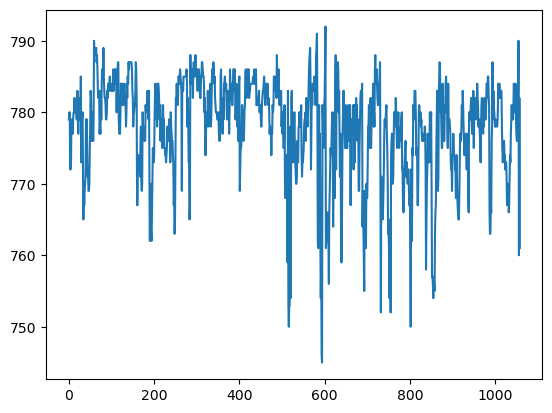

In [4]:
plt.plot(res_TN['air_snow_index'])

In [45]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import cmasher as cmr
import matplotlib.font_manager as font_manager
import matplotlib.colors as mcolors
import geopandas as gpd
font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
path_to_shapes = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v4/'

site = gpd.read_file(os.path.join(path_to_shapes, f'EUREKA2014_transect_measurement_bounds.shp'))

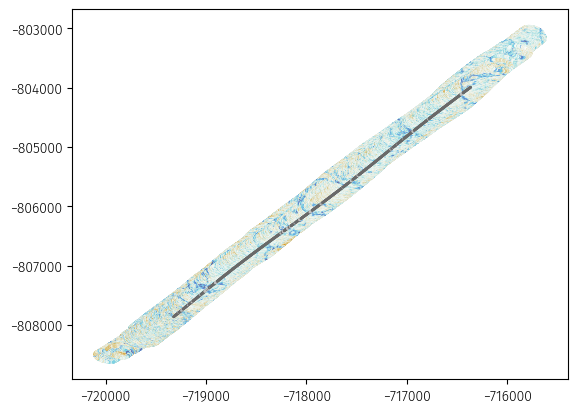

In [31]:
scat1 = plt.scatter(df_ATM['x'], df_ATM['y'],
            s=1,
            c=df_ATM['elev_levelled'],
            cmap=cmr.prinsenvlag,
            vmin=-.4,
            vmax=.4,
            # transform=ccrs.epsg(3413),
            zorder=100
            )

scat2 = plt.scatter(res_TN['x'], res_TN['y'], s=1, c=res_TN['ATM_classes'],
                    cmap=mcolors.ListedColormap(['dimgrey','silver']),
                    norm=mcolors.Normalize(vmin=0, vmax=1),
                    # transform=ccrs.epsg(3413),
                    zorder=102
                    )


/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_90258/4082716829.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax0.pcolormesh(res_TN['lat'], res_TN['elevation_axii'], 10 * np.log10(res_TN['radar_data']), cmap='Greys',)


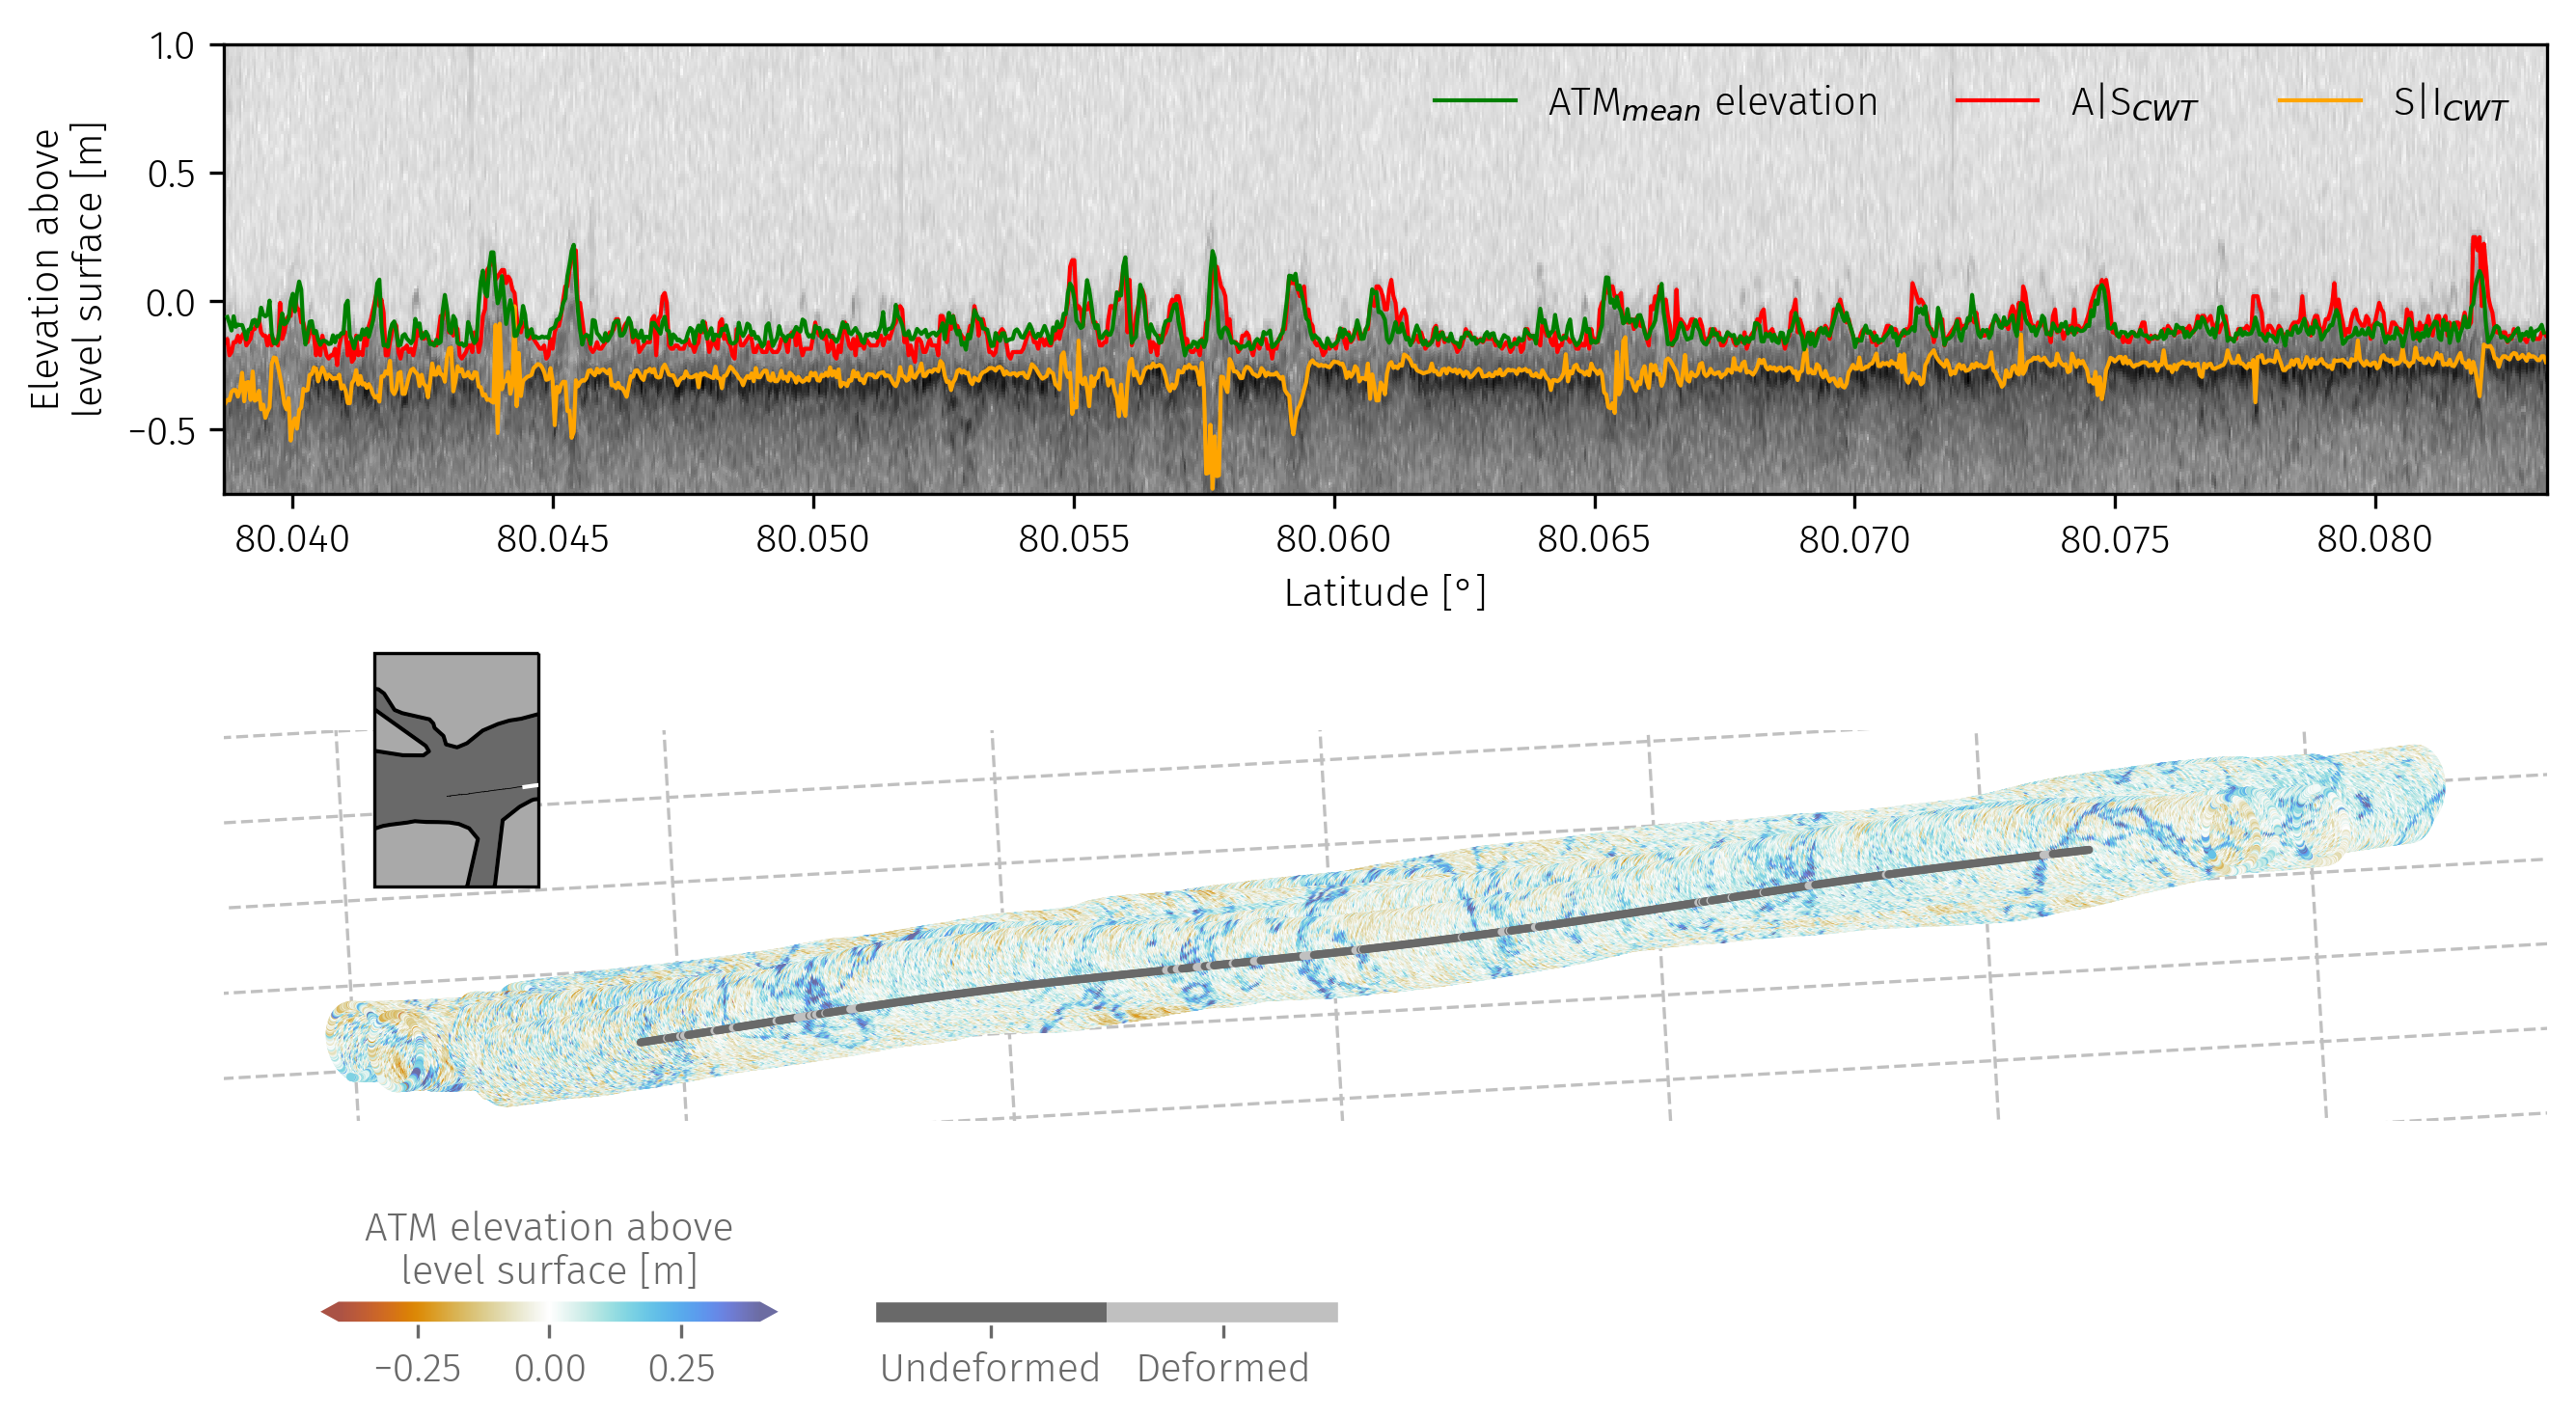

In [59]:
offset = np.nanmean(res_TN['air_snow_elevation'] - res_TN['ATM_as_interfaces_mean'])
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(9,5), dpi=300, tight_layout=True)
gs = GridSpec(2, 1, height_ratios=[1, 1.5], figure=fig)
ax0 = fig.add_subplot(gs[0])  # Row 0, all columns
ax1 = fig.add_subplot(gs[1], projection=ccrs.NorthPolarStereo())  # Row 1, first column


ax0.pcolormesh(res_TN['lat'], res_TN['elevation_axii'], 10 * np.log10(res_TN['radar_data']), cmap='Greys',)
ax0.plot(res_TN['lat'], res_TN['ATM_as_interfaces_mean'] + offset, color='green', label='ATM$_{mean}$ elevation', lw=1, zorder=100)

ax0.plot(res_TN['lat'], res_TN['air_snow_elevation'], color='red', label='A|S$_{CWT}$', lw=1)
ax0.plot(res_TN['lat'], res_TN['snow_ice_elevation'], color='orange', label='S|I$_{CWT}$', lw=1)   

ax0.set_ylim(-.75, 1)
# ax0.set_xlim(right=89.960)
ax0.set_xlabel('Latitude [°]')
ax0.set_ylabel('Elevation above\nlevel surface [m]')
ax0.legend(frameon=False, loc='upper right', ncols=3)



# ax1 = fig.add_subplot(2,1,2, projection=ccrs.NorthPolarStereo())
gl = ax1.gridlines(ls='--', draw_labels=True, color='silver')
gl.xlabel_style = {'color': 'silver'}
gl.ylabel_style = {'color': 'silver', 'rotation': 90}

# ax1.add_feature(cfeature.OCEAN, color='dimgrey')
ax1.set_aspect('equal')
ax1.axis('off')
scat1 = ax1.scatter(df_ATM['x'], df_ATM['y'],
            s=1,
            c=df_ATM['elev_levelled'],
            cmap=cmr.prinsenvlag,
            vmin=-.4,
            vmax=.4,
            transform=ccrs.epsg(3413),
            zorder=100
            )

scat2 = ax1.scatter(res_TN['x'], res_TN['y'], s=1, c=res_TN['ATM_classes'],
                    cmap=mcolors.ListedColormap(['dimgrey','silver']),
                    norm=mcolors.Normalize(vmin=0, vmax=1),
                    transform=ccrs.epsg(3413),
                    zorder=102
                    )

cbar = fig.colorbar(scat1, ax=ax1,
                    label='ATM elevation above\nlevel surface [m]',
                    orientation='horizontal',
                    extend='both',
                    anchor=(0.05,0),
                    pad=-0.15,
                    shrink=.2
                    )

cbar.outline.set_edgecolor('white')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_tick_params(color='dimgrey', labelcolor='dimgrey')
cbar.ax.yaxis.set_tick_params(color='dimgrey', labelcolor='dimgrey')
cbar.ax.xaxis.label.set_color('dimgrey')


cbar2 = fig.colorbar(scat2, ax=ax1,
                    orientation='horizontal',
                    anchor=(0.35,0),
                    # pad=-0.25,
                    shrink=.2
                    )
cbar2.set_ticks([0.25,0.75])
cbar2.set_ticklabels(['Undeformed', 'Deformed']) 
# 
cbar2.outline.set_edgecolor('white')
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.xaxis.set_tick_params(color='dimgrey', labelcolor='dimgrey')
cbar2.ax.yaxis.set_tick_params(color='dimgrey', labelcolor='dimgrey')
cbar2.ax.xaxis.label.set_color('dimgrey')

# fig.subplots_adjust(hspace=-.5) 

inset = ax1.inset_axes([0, 0.6, 0.2, 0.6], projection=ccrs.NorthPolarStereo())
inset.set_extent((272.3, 274, 79.85, 80.05))
inset.add_feature(cfeature.OCEAN, color='dimgrey')
inset.add_feature(cfeature.LAND, color='darkgrey')
inset.coastlines(resolution='10m', color='black')
inset.plot(site.loc[0].geometry.exterior.xy[0], site.loc[0].geometry.exterior.xy[1], color='black', lw=.1, transform=ccrs.epsg(3413))
inset.plot(res_TN['x'], res_TN['y'], color='white', lw=1, transform=ccrs.epsg(3413), zorder=100)


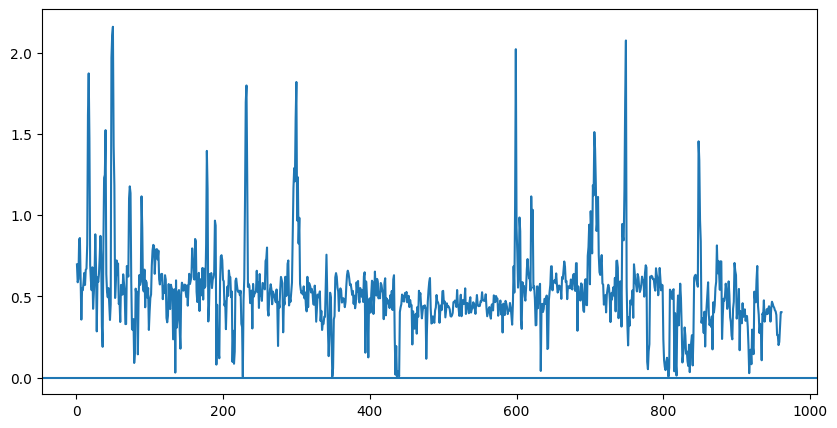

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(abs(res_TN['air_snow_elevation'] - res_TN['ATM_as_interfaces_90']))
# ax.plot(res_TN['ATM_as_interfaces_90'])

# ax.plot(res_TN['snow_ice_SNR'])
ax.axhline(0)
# ax.set_ylim(-100,100)

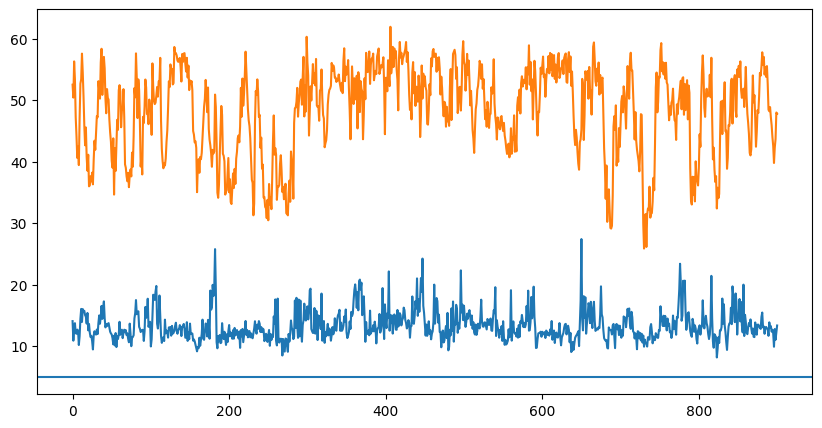

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(res_TN['air_snow_SNR'])
ax.plot(res_TN['snow_ice_SNR'])
ax.axhline(5)

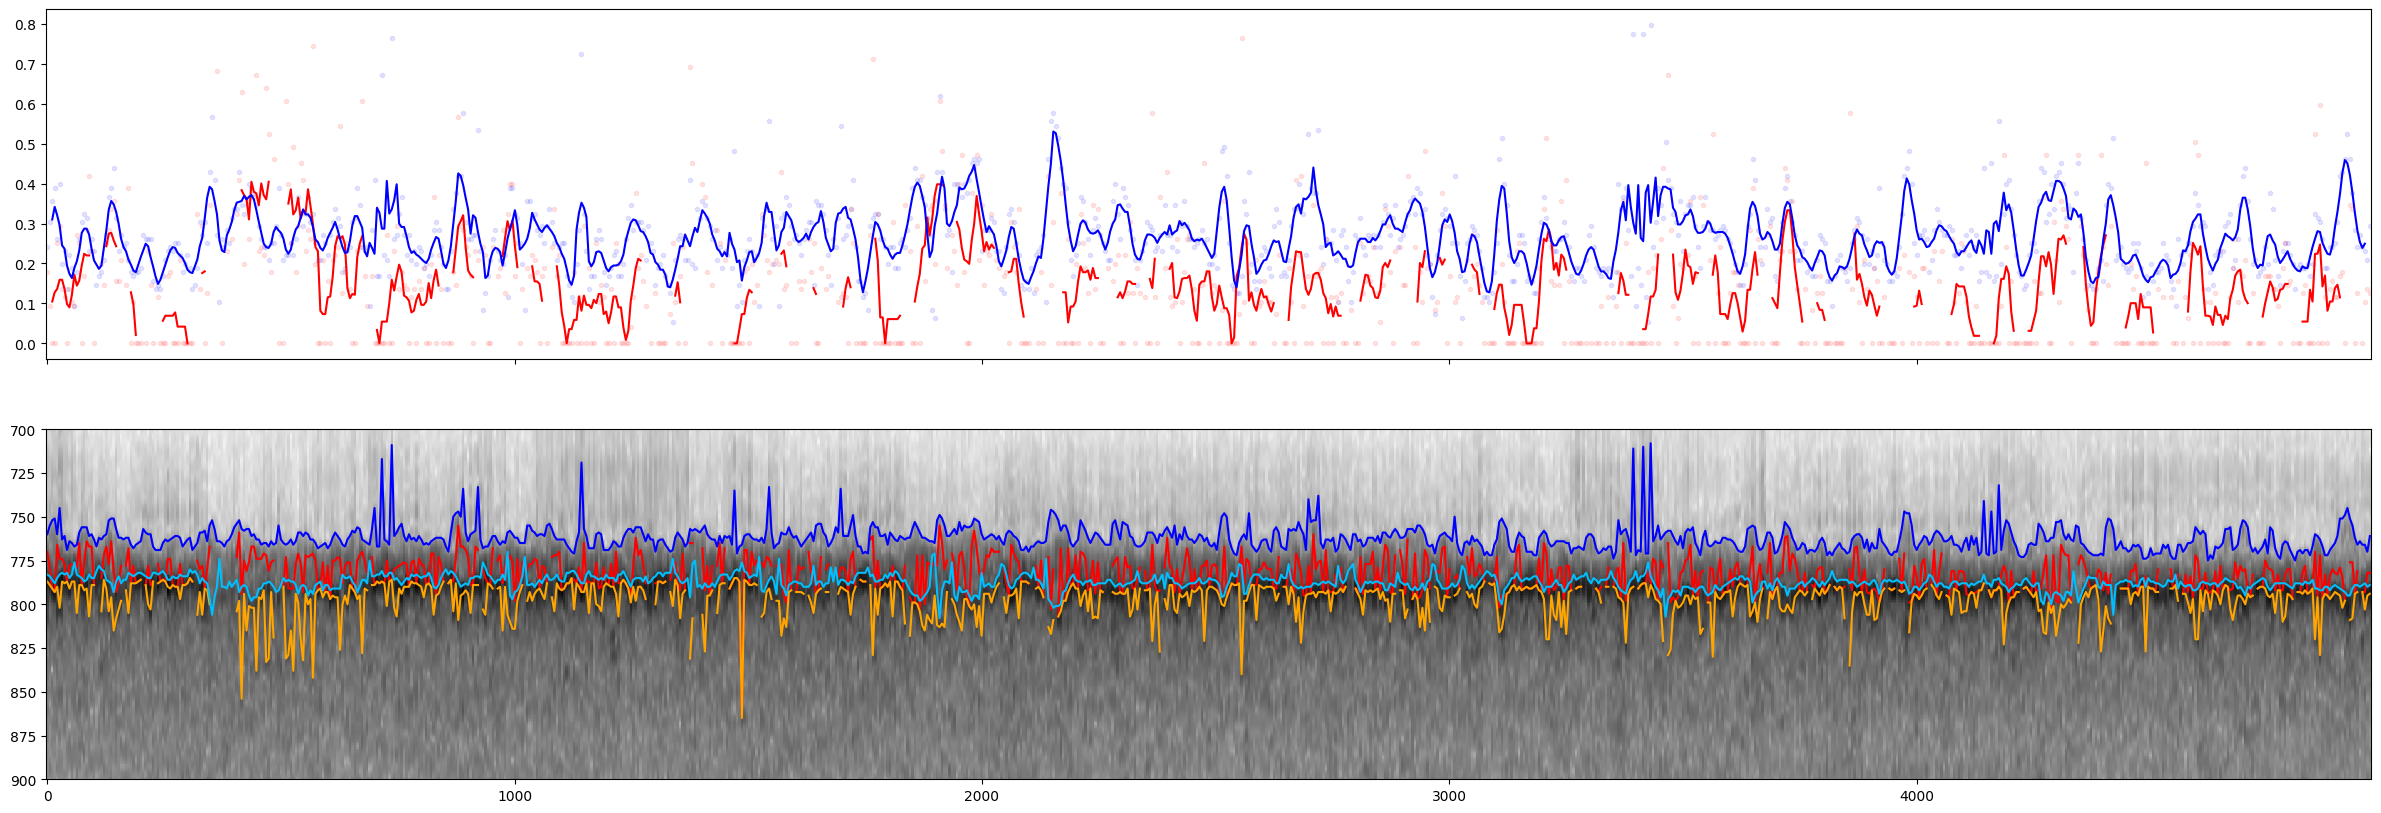

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(30,10), sharex=True)
# _, Y = np.meshgrid(range(len(res_Peaki['range_bin'])), res_Peaki['along_track_distance'])

ax[0].plot(pd.Series(res_Peaki['along_track_distance']).rolling(window=5, center=True).mean(), pd.Series(res_Peaki['snow_depth']).rolling(window=5, center=True).mean(), color='red')
ax[0].plot(pd.Series(res_TN['along_track_distance']).rolling(window=5, center=True, ).mean(), pd.Series(res_TN['snow_depth']).rolling(window=5, center=True).mean(), color='blue')

ax[0].scatter(res_TN['along_track_distance'], res_TN['snow_depth'], color='blue', alpha=.1, marker='.')
ax[0].scatter(res_Peaki['along_track_distance'], res_Peaki['snow_depth'], color='red', alpha=.1, marker='.')

ax[1].pcolormesh(res_Peaki['along_track_distance'], res_Peaki['range_bin'],  10 * np.log10(res_Peaki['radar_data']),cmap='Greys')

ax[1].plot(res_Peaki['along_track_distance'], res_Peaki['air_snow_index'], 'red')
ax[1].plot(res_Peaki['along_track_distance'], res_Peaki['snow_ice_index'], 'orange')

ax[1].plot(res_TN['along_track_distance'], res_TN['air_snow_index'], 'blue')
ax[1].plot(res_TN['along_track_distance'], res_TN['snow_ice_index'], 'deepskyblue')

# ax.plot(res_Peaki2['along_track_distance'], res_Peaki2['air_snow_index'], 'blue')
# ax.plot(res_Peaki2['along_track_distance'], res_Peaki2['snow_ice_index'], 'deepskyblue')
# ax.plot(res_Peaki['along_track_distance'], res_Peaki['max_elevation'], 'g')

# ax.plot(res_TN['along_track_distance'], , 'b')

ax[1].set_ylim(700,900)
# ax.set_xlim(0, 400)

ax[1].invert_yaxis()

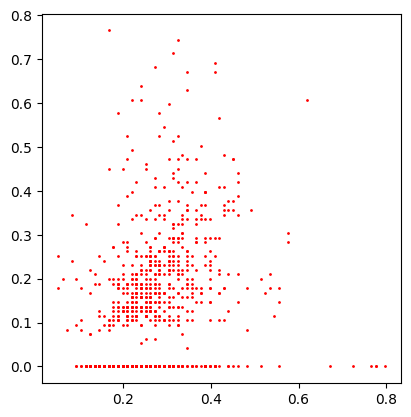

In [41]:
fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
# ax.scatter(pd.Series(res_TN['snow_depth']).rolling(window=5, center=True).mean(), pd.Series(res_Peaki['snow_depth']).rolling(window=5, center=True).mean(), color='red')
ax.scatter(pd.Series(res_TN['snow_depth']), pd.Series(res_Peaki['snow_depth']), color='red', s=1)


/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_82752/3729034650.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol = ax.pcolormesh(Y.T, res_TN['elevation_axii'],  10 * np.log10(res_TN['radar_data']),cmap='Greys');


(-1.0, 1.0)

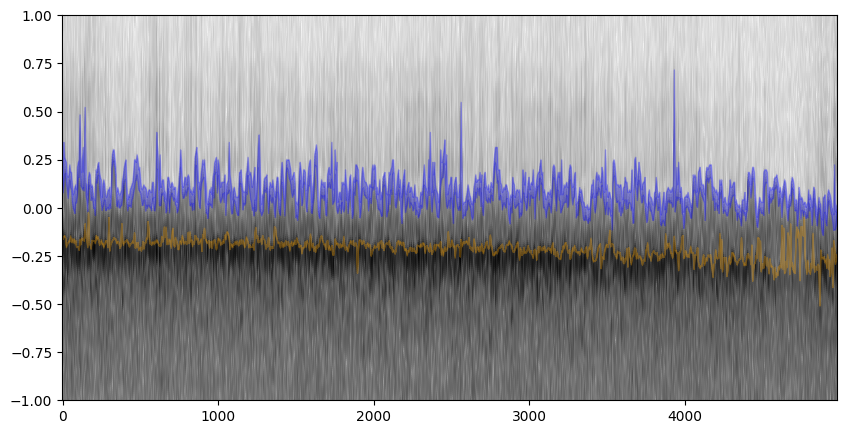

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
_, Y = np.meshgrid(range(len(res_TN['range_bin'])), res_TN['along_track_distance'])

pcol = ax.pcolormesh(Y.T, res_TN['elevation_axii'],  10 * np.log10(res_TN['radar_data']),cmap='Greys');
ax.fill_between(res_TN['along_track_distance'], res_TN['air_snow_left_elevation'], res_TN['air_snow_right_elevation'], color='blue', alpha=0.3)
ax.fill_between(res_TN['along_track_distance'], res_TN['snow_ice_left_elevation'], res_TN['snow_ice_right_elevation'], color='orange', alpha=0.3)

ax.set_ylim(-1,1)

NameError: name 'res_TN' is not defined

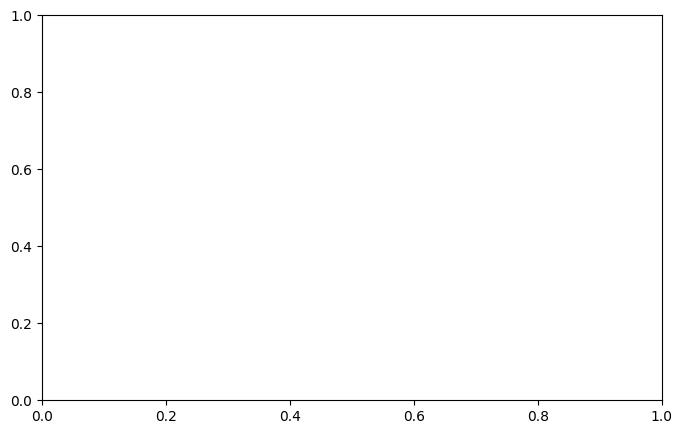

In [35]:
ind  = 200

fig, ax = plt.subplots(1,figsize=(8,5),sharex=True)

ax.plot(res_TN['range_bin'], 10 * np.log10(radar_dat.data_radar[:,ind]), color='black')   
# ax.plot(ds['radar_data'][:,ind], color='black')   

# ax.invert_xaxis()

ax2 = ax.twinx()
# ax2.plot(ds['wavelet_coefs_lin'][:,ind])

ax.axvline(res_TN['snow_ice_index'][ind])
ax.axvline(res_TN['air_snow_index'][ind])


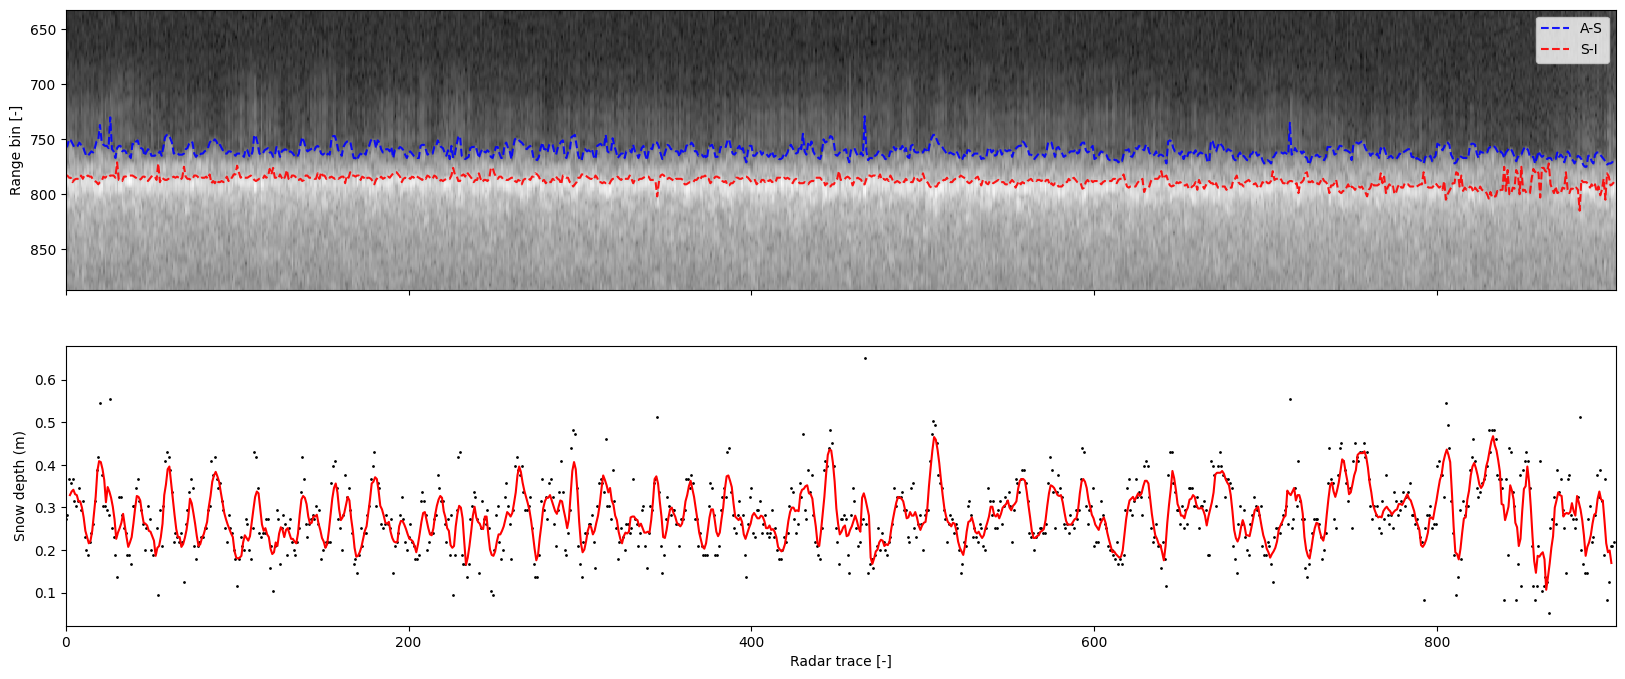

In [8]:
# Plot interface picks and snow depth
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8), sharex=True)
ax1.imshow(10 * np.log10(radar_dat.data_radar/np.nanmax(radar_dat.data_radar)), interpolation='none', cmap="gist_gray",  aspect='auto')
ax1.plot(res_TN['air_snow_index'], linestyle='--', color='b',alpha=0.9,label='A-S')
ax1.plot(res_TN['snow_ice_index'], linestyle='--', color='r',alpha=0.9,label='S-I')
ax1.legend(loc="upper right")


# Rolling average of depth over 5 bins
N = 5
snow_depth_rolling = np.convolve(res_TN['snow_depth'], np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rolling)+(N/2)

ax2.scatter(np.arange(0,len(res_TN['snow_depth'])), res_TN['snow_depth'], color = 'k', s = 1)
ax2.plot(np.arange(estart, eend),snow_depth_rolling, color='r')


ax1.set_ylim(radar_bounds)
ax2.set_xlim(0, len(res_TN['snow_depth']))
ax1.set_ylabel("Range bin [-]")
ax2.set_ylabel("Snow depth (m)")
ax2.set_xlabel("Radar trace [-]");

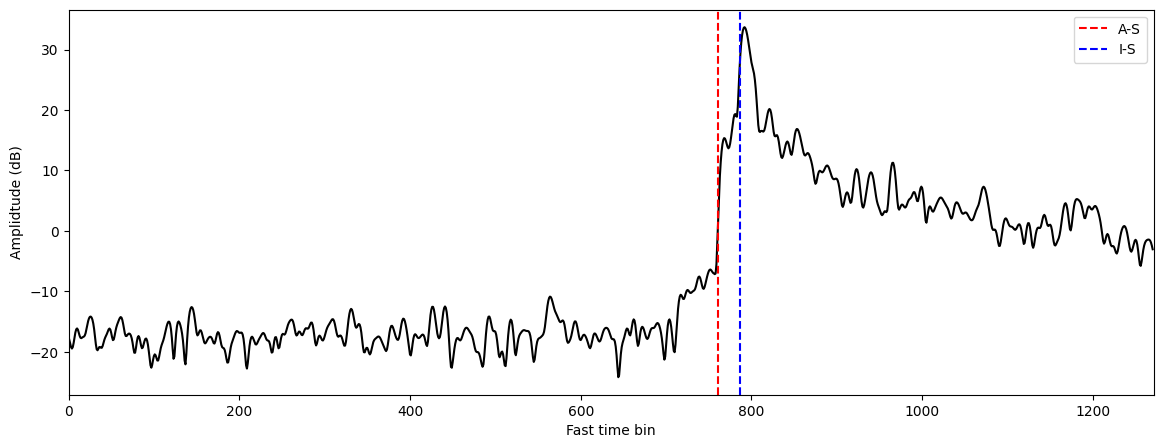

In [31]:
col_idx = np.random.randint(0,radar_dat.data_radar.shape[1])
fig, ax = plt.subplots(figsize=(14,5))




with np.errstate(divide='ignore'):
    ax.plot(10*np.log10(radar_dat.data_radar[:,col_idx]), color = 'k', label=None)

# Air-Snow picked interface
ax.vlines(res_TN['air_snow_index'][col_idx], 0, 1, label='A-S', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(res_TN['snow_ice_index'][col_idx], 0, 1, label='I-S', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')

ax.set_xlim(0, len(radar_dat.data_radar[:,col_idx]))
ax.set_xlabel("Fast time bin")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right");